<a href="https://colab.research.google.com/github/Gruppe3VDL/Gruppe3VDLws2019/blob/master/exercise3/task1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation

In [1]:
import collections
import datetime
import os
import zipfile
import numpy as np
import torch
import torch.nn as nn
import yaml

from os import listdir, makedirs
from os.path import join, splitext
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

# Check cuda
torch.manual_seed(1337)
cuda = torch.cuda.is_available()
print('cuda:', cuda)
if cuda:
    torch.cuda.manual_seed(1337)

cuda: True


## 1. Get the Dataset
Download and extract the bags dataset
https://drive.google.com/file/d/1P4bdP6nSUOqQLhGXvZ1z4z3hNncJFrCs

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#########################################################################
## Navigate to the exercise directory.                                 ##
##                                                                     ##
## IMPORTANT:                                                          ##
## Either change the path below to the exercise folder in your drive   ##
## or put the folder at same path in your drive (recommended).         ##
#########################################################################

%cd 'drive/My Drive/TUK/Very Deep Learning/Exercises/exercise3/'

/content/drive/My Drive/TUK/Very Deep Learning/Exercises/exercise3


In [4]:
#########################################################################
## Extract bags dataset.                                               ##
#########################################################################

if not os.path.exists('data/bags_data'):
  print("Extracting dataset...")
  with zipfile.ZipFile("data/bags_data.zip","r") as zip_ref:
      zip_ref.extractall("data/")
  print("Done.")
else:
  print("Dataset already extracted.")

Dataset already extracted.


## 2. Read the Dataset
Write a ```pytorch``` [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class which can iterate over the dataset. (Hint: Get inspiration from the [```pytorch``` tutorials](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html))

In [5]:
#########################################################################
## Define dataset paths.                                               ##
#########################################################################

root = 'data/bags_data/'
%ls $root

imags_dir = root + 'JPEGImages/'
masks_dir = root + 'segmentation_mask/'
imagesets = root + 'imagesets/'

imagesets/  JPEGImages/  segmentation_mask/


In [6]:
#########################################################################
## Calculate chromatic mean of the dataset.                            ##
#########################################################################

# # Open all images and segmentation masks
# files = [splitext(i)[0] for i in sorted(listdir(imags_dir))]
# imags = [np.array(Image.open(join(imags_dir, splitext(i)[0] + ".jpg"))) for i in files]
# masks = [np.array(Image.open(join(masks_dir, splitext(i)[0] + ".png"))) for i in files]

# # Extract backgrounds by removing bags from images
# bgrs = []
# for i in range(len(imags)):
#     bgr = np.copy(imags[i])
#     idx = (masks[i] != 0)
    
#     bgr[idx] = 0
#     bgrs.append(bgr)

# # Find chromatic means for orginal and processed images
# def find_mean(imgs):
#     means = np.stack([i.mean(axis=0).mean(axis=0) for i in imgs], axis=0)
#     return means.mean(axis=0)

mean_normal = [149.51536146, 132.39143821, 126.18532193] # find_mean(imags)
mean_masked = [101.33193905, 97.80411118, 92.44720252] # find_mean(bgrs)

# Report means
print('mean (images):', mean_normal)
print('mean (masked):', mean_masked)

mean (images): [149.51536146, 132.39143821, 126.18532193]
mean (masked): [101.33193905, 97.80411118, 92.44720252]


In [7]:
#########################################################################
## Define a custom dataset class which can be used with PyTorch data   ##
## loaders.                                                            ##
#########################################################################

class BagsDataset(Dataset):
    """Bags dataset."""
    def __init__(self, root, mean, split='train', transform=False):
        self.root = root
        self.mean = np.array(mean)
        self.split = split
        self.class_names = np.array(['background', 'bag'])
        self._transform = transform

        self.files = collections.defaultdict(list)
        for split in ['train', 'val']:
            ids_file = join(root, 'imagesets/%s.txt' % split)
            for idx in open(ids_file):
                idx = idx.strip()
                self.files[split].append({
                    'image': join(root, 'JPEGImages/%s.jpg' % idx),
                    'label': join(root, 'segmentation_mask/%s.png' % idx),
                })

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        data_file = self.files[self.split][index]

        # Load image
        image = Image.open(data_file['image'])
        image = image.resize((512, 512))
        image = np.array(image, dtype=np.uint8)

        # Load label
        label = Image.open(data_file['label'])
        label = label.resize((512, 512))
        label = np.array(label, dtype=np.int32)
        label[label == 255] = -1

        if self._transform:
            return self.transform(image, label)
        else:
            return image, label

    def transform(self, image, label):
        # Transform image
        image = image.astype(np.float64)        # uint8 -> float64
        image -= self.mean                      # Remove mean
        image = np.transpose(image, (2, 0, 1))  # (W, H, C) -> (C, W, H)
        image = torch.from_numpy(image).float() # To tensor

        # Transform label
        label = torch.from_numpy(label).long()  # To tensor

        return image, label

    def untransform(self, image, label):
        # Restore image
        image = image.numpy()                   # To numpy array
        image = np.transpose(image, (1, 2, 0))  # (C, W, H) -> (W, H, C)
        image += self.mean                      # Restore mean
        image = image.astype(np.uint8)          # float64 -> uint8

        # Restore label
        label = label.numpy()                   # To numpy array

        return image, label

# Load datasets
print("Loading training set...")
traindata = BagsDataset(root, mean_normal, split='train', transform=True)
print(len(traindata), "images in train set.\n")

print("Loading validation set...")
valdata = BagsDataset(root, mean_normal, split='val', transform=True)
print(len(valdata), "images in validation set.\n")

Loading training set...
427 images in train set.

Loading validation set...
107 images in validation set.



Creating data loaders...
Show sample batch from created datasets...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])
torch.Size([3, 512, 512])


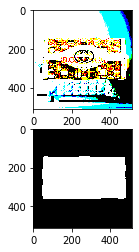

In [8]:
#########################################################################
## Create and validate dataloaders.                                    ##
#########################################################################

# Define training and validation dataloaders.
print("Creating data loaders...")
kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
train_loader = DataLoader(traindata, batch_size=1, shuffle=True, **kwargs)
val_loader = DataLoader(valdata, batch_size=1, shuffle=False, **kwargs)

# Show some of the loaded images to verify dataloaders.
def convert_img(im, mask=False):
  print(im.shape)
  im = im.numpy()
  im = np.transpose(im, (1, 2, 0))
  if mask:
    im = im / np.max(im)

  return im

print("Show sample batch from created datasets...")
sample = iter(train_loader).next()

ax = plt.subplot(2, 1, 1)
plt.imshow(convert_img(make_grid(sample[0])))

ax = plt.subplot(2, 1, 2)
plt.imshow(convert_img(make_grid(sample[1]), mask=True))

## 3. Train a FCN for Segmentation
Train a fully-convolutional network on the training dataset.
Hint: You can either define your own FCN or use an already implemented model (e.g. https://github.com/wkentaro/pytorch-fcn)

In [9]:
#########################################################################
## Install PyTorch-FCN.                                                ##
#########################################################################

!pip install torchfcn
import torchfcn

In [63]:
#########################################################################
## Create and train network.                                           ##
#########################################################################

# Define training parameters
def get_parameters(model, bias=False):
    modules_skipped = (
        nn.ReLU,
        nn.MaxPool2d,
        nn.Dropout2d,
        nn.Sequential,
        torchfcn.models.FCN32s,
        torchfcn.models.FCN16s,
        torchfcn.models.FCN8s,
    )

    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if bias:
                yield m.bias
            else:
                yield m.weight
        elif isinstance(m, nn.ConvTranspose2d):
            # weight is frozen because it is just a bilinear upsampling
            if bias:
                assert m.bias is None
        elif isinstance(m, modules_skipped):
            continue
        else:
            raise ValueError('Unexpected module: %s' % str(m))

# Create model
net = torchfcn.models.FCN8s(n_class=2)
if cuda:
  net = net.cuda()

# Define an optimizer
optim = torch.optim.SGD([{'params': get_parameters(net, bias=False)},
                         {'params': get_parameters(net, bias=True), 
                          'lr': 1.0e-14 * 2, 'weight_decay': 0}], 
                        lr=1.0e-14, momentum=0.99, weight_decay=0.0005)

# Create the trainer
logfile = join('logs', datetime.datetime.now().strftime('%Y%m%d_%H%M%S.%f'))
trainer = torchfcn.Trainer(
    cuda=cuda,
    model=net,
    optimizer=optim,
    train_loader=train_loader,
    val_loader=val_loader,
    out=logfile,
    max_iter=500
)

# Start training
trainer.epoch = 0
trainer.iteration = 0
trainer.train()

# Validate
trainer.validate()






















Train:   0%|                                              | 0/2 [00:00<?, ?it/s]





















Train epoch=0:   0%|                                    | 0/427 [00:00<?, ?it/s]






















Valid iteration=0:   0%|                                | 0/107 [00:00<?, ?it/s]






















Valid iteration=0:   1%|▏                       | 1/107 [00:01<02:31,  1.43s/it]






















Valid iteration=0:   2%|▍                       | 2/107 [00:02<02:18,  1.32s/it]






















Valid iteration=0:   3%|▋                       | 3/107 [00:03<02:08,  1.23s/it]






















Valid iteration=0:   4%|▉                       | 4/107 [00:04<02:00,  1.17s/it]






















Valid iteration=0:   5%|█                       | 5/107 [00:05<01:55,  1.13s/it]






















Valid iteration=0:   6%|█▎                      | 6/107 [00:06<01:51,  1.10s/it]






















Valid iteration=0:   7%|█▌                      | 7/1

## 4. Calculate IoU Score
Report the mean IoU score after each epoch for both training dataset and validation dataset

In [58]:
import pandas as pd

print(logfile)
log = pd.read_csv(join('logs/20191215_162149.094655/', 'log.csv'))
# log = pd.read_csv(join(logfile, 'log.csv'))
for epoch in np.unique(log['epoch']):
    iters = log.loc[log['epoch'] == epoch]

    iu_train = iters.sum(axis = 0, skipna = True)['train/mean_iu']
    mean_iut = iu_train / iters.shape[0]

    iu_valid = iters.sum(axis = 0, skipna = True)['valid/mean_iu']
    mean_iuv = iu_valid / iters.shape[0]
    print('epoch: %d, train_iou: %.4f, val_iou: %.4f' % (epoch, mean_iut, mean_iuv))

logs/20191215_164215.688520
epoch: 0, train_iou: 0.3153, val_iou: 0.0007
epoch: 1, train_iou: 0.3168, val_iou: 0.0000
epoch: 2, train_iou: 0.3067, val_iou: 0.0000


## 5. Visualize Network Output
Visualize your network output on one image of the validation set